In [1]:
# Running PyTorch on MPS
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
from PIL import Image

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
!pip list

Package                            Version
---------------------------------- --------------
absl-py                            2.1.0
accelerate                         0.31.0
aiofiles                           23.2.1
aiohttp                            3.9.5
aiosignal                          1.3.1
altair                             5.3.0
annotated-types                    0.7.0
anyio                              4.4.0
appnope                            0.1.4
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
arrow                              1.3.0
asttokens                          2.4.1
async-lru                          2.0.4
attrs                              23.2.0
Babel                              2.15.0
beautifulsoup4                     4.12.3
bleach                             6.1.0
blis                               0.7.11
boto3                              1.34.138
botocore                           1.34.138
bpemb                           

In [3]:
test_dir = Path("test/")
train_dir = Path("train/")
exp_dir = Path("examples/")

train_dir, exp_dir

(PosixPath('train'), PosixPath('examples'))

In [4]:
train_path_list = list(train_dir.glob("*/*.png"))
test_path_list = list(test_dir.glob("*/*.png"))
exp_list = list(exp_dir.glob("*.png"))
exp_list

[PosixPath('examples/dark.png'),
 PosixPath('examples/medium.png'),
 PosixPath('examples/light.png'),
 PosixPath('examples/green.png')]

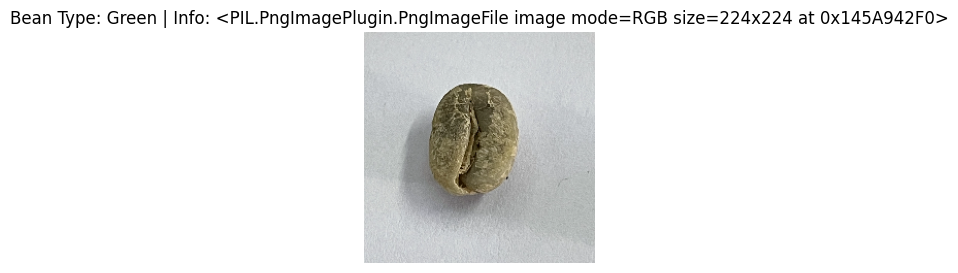

In [6]:
rand_img_path = random.choice(train_path_list)
img_class = rand_img_path.parent.stem
img = Image.open(rand_img_path)

img_as_arr = np.asarray(img)

plt.figure(figsize=(3,3))
plt.imshow(img_as_arr)
plt.title(f"Bean Type: {img_class} | Info: {img}")
plt.axis(False);

In [7]:
# PARAMETERS
effnetv2_s_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
effnetv2_s_transforms = effnetv2_s_weights.transforms()
effnetb1_weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
effnetb1_transforms = effnetb1_weights.transforms()

BATCH_SIZE = 32
NUM_WORKERS = 0 # for mps activation
effnetv2_s_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
train_data = datasets.ImageFolder(train_dir, transform=effnetv2_s_transforms)
test_data = datasets.ImageFolder(test_dir, transform=effnetv2_s_transforms)
train_data, test_data
class_names = train_data.classes
class_names
train_data.class_to_idx

{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

In [9]:
# Import Model
from torchinfo import summary

effnetv2_s = torchvision.models.efficientnet_v2_s(weights=effnetv2_s_weights)

for params in effnetv2_s.parameters():
    params.requires_grad = False


effnetv2_s.classifier = torch.nn.Sequential(
    nn.Dropout(p=0, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(mps_device)
)

summary(effnetv2_s, 
        input_size=(1, 3, 384, 384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 4]               --                   Partial
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 2

In [10]:
# Dataloaders 
train_dataloader = DataLoader(train_data, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True,
                               num_workers=NUM_WORKERS,
                               pin_memory=True)

test_dataloader = DataLoader(test_data, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                               num_workers=NUM_WORKERS,
                               pin_memory=True)

In [12]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X).to(device)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [13]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os

def model_writer(model: str,
                 add: str=None) -> torch.utils.tensorboard.SummaryWriter:

    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if add:
        # Create log path
        log_dir = os.path.join("runs", timestamp, model, add)
    else:
        log_dir = os.path.join("runs", timestamp, model)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [14]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          writer: torch.utils.tensorboard.SummaryWriter,
          device: torch.device) -> Dict[str, List]: # {name of metric, list of scalar data for epoch}

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        # Writer 
        if writer:
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)
            writer.close()
        else:
            pass

    return results

In [16]:
# Multi-Class Problem
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetv2_s.parameters(), lr=0.001)

# results = train(model=effnetv2_s.to(mps_device),
#                 train_dataloader=train_dataloader,
#                 test_dataloader=test_dataloader,
#                 optimizer=optimizer,
#                 loss_fn=loss_fn,
#                 epochs=5,
#                 writer=effnetv2_s_writer,
#                 device=mps_device)

In [17]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
               f=model_save_path)


In [19]:
from modules.model_builder import build_effnet_v2_s, build_effnetb1
from modules.data_setup import create_dataloaders
from modules.utils import save_model

experiment_number = 0

models = ["effnet_v2_s", "effnetb1"]
num_epochs = [5, 10]

for epochs in num_epochs:
    for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # Select the model
            if model_name == "effnet_v2_s":
                model, weights = build_effnet_v2_s(mps_device)
            else:
                model, weights = build_effnetb1(mps_device)
                
            train_dataloader, test_dataloader = create_dataloaders(train_dir,
                                                       test_dir,
                                                       transform=weights.transforms(),
                                                       batch_size=32,
                                                       num_workers=0)
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model.to(mps_device) ,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=mps_device,
                  writer=model_writer(model_name,
                                       add=f"{epochs}_epochs"))
            
            save_filepath = f"07_{model_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnet_v2_s
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2024-07-15/effnet_v2_s/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8738 | train_acc: 0.7887 | test_loss: 0.4785 | test_acc: 0.9519
Epoch: 2 | train_loss: 0.4098 | train_acc: 0.9441 | test_loss: 0.2737 | test_acc: 0.9712
Epoch: 3 | train_loss: 0.2847 | train_acc: 0.9589 | test_loss: 0.2037 | test_acc: 0.9760
Epoch: 4 | train_loss: 0.2305 | train_acc: 0.9638 | test_loss: 0.1579 | test_acc: 0.9832
Epoch: 5 | train_loss: 0.1932 | train_acc: 0.9613 | test_loss: 0.1341 | test_acc: 0.9880
[INFO] Saving model to: models/07_effnet_v2_s_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb1
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2024-07-15/effnetb1/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9280 | train_acc: 0.8808 | test_loss: 0.5659 | test_acc: 0.9856
Epoch: 2 | train_loss: 0.4426 | train_acc: 0.9663 | test_loss: 0.2952 | test_acc: 0.9952
Epoch: 3 | train_loss: 0.2842 | train_acc: 0.9753 | test_loss: 0.2027 | test_acc: 0.9952
Epoch: 4 | train_loss: 0.2092 | train_acc: 0.9819 | test_loss: 0.1533 | test_acc: 0.9976
Epoch: 5 | train_loss: 0.1738 | train_acc: 0.9868 | test_loss: 0.1238 | test_acc: 0.9976
[INFO] Saving model to: models/07_effnetb1_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnet_v2_s
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs/2024-07-15/effnet_v2_s/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8528 | train_acc: 0.7845 | test_loss: 0.5124 | test_acc: 0.9159
Epoch: 2 | train_loss: 0.4128 | train_acc: 0.9334 | test_loss: 0.2952 | test_acc: 0.9663
Epoch: 3 | train_loss: 0.2984 | train_acc: 0.9465 | test_loss: 0.2249 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.2334 | train_acc: 0.9605 | test_loss: 0.1610 | test_acc: 0.9784
Epoch: 5 | train_loss: 0.2002 | train_acc: 0.9663 | test_loss: 0.1237 | test_acc: 0.9808
Epoch: 6 | train_loss: 0.1630 | train_acc: 0.9712 | test_loss: 0.1171 | test_acc: 0.9856
Epoch: 7 | train_loss: 0.1711 | train_acc: 0.9589 | test_loss: 0.1123 | test_acc: 0.9832
Epoch: 8 | train_loss: 0.1426 | train_acc: 0.9720 | test_loss: 0.0872 | test_acc: 0.9880
Epoch: 9 | train_loss: 0.1162 | train_acc: 0.9770 | test_loss: 0.0809 | test_acc: 0.9904
Epoch: 10 | train_loss: 0.1216 | train_acc: 0.9696 | test_loss: 0.4859 | test_acc: 0.9856
[INFO] Saving model to: models/07_effnet_v2_s_10_epochs.pth
-------------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9316 | train_acc: 0.8832 | test_loss: 0.5716 | test_acc: 0.9808
Epoch: 2 | train_loss: 0.4586 | train_acc: 0.9622 | test_loss: 0.3069 | test_acc: 0.9928
Epoch: 3 | train_loss: 0.2867 | train_acc: 0.9786 | test_loss: 0.1979 | test_acc: 0.9976
Epoch: 4 | train_loss: 0.2048 | train_acc: 0.9885 | test_loss: 0.1483 | test_acc: 0.9976
Epoch: 5 | train_loss: 0.1700 | train_acc: 0.9836 | test_loss: 0.1226 | test_acc: 0.9976
Epoch: 6 | train_loss: 0.1461 | train_acc: 0.9811 | test_loss: 0.0974 | test_acc: 0.9976
Epoch: 7 | train_loss: 0.1214 | train_acc: 0.9877 | test_loss: 0.0838 | test_acc: 0.9976
Epoch: 8 | train_loss: 0.1121 | train_acc: 0.9901 | test_loss: 0.0706 | test_acc: 0.9976
Epoch: 9 | train_loss: 0.0999 | train_acc: 0.9910 | test_loss: 0.0685 | test_acc: 0.9976
Epoch: 10 | train_loss: 0.0911 | train_acc: 0.9910 | test_loss: 0.0591 | test_acc: 0.9976
[INFO] Saving model to: models/07_effnetb1_10_epochs.pth
--------------------------------------------------



In [20]:
%load_ext tensorboard
%tensorboard --logdir runs

In [22]:
from modules.model_builder import build_effnet_v2_s, build_effnetb1
from modules.data_setup import create_dataloaders
from modules.utils import save_model

model, weights = build_effnetb1(mps_device)
model_transforms = weights.transforms()
model_transforms


ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [23]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple
from PIL import Image

# Set device
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (255, 255),
    transform: torchvision.transforms = None,
    device: torch.device = mps_device,
):

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # Plot image with predicted label and probability
    plt.figure(figsize=(3,2))
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)



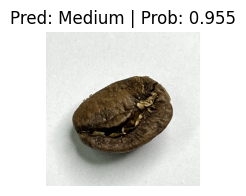

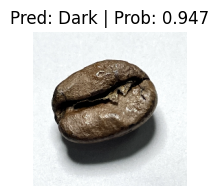

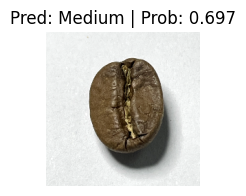

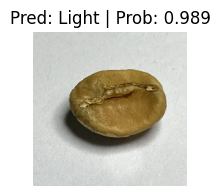

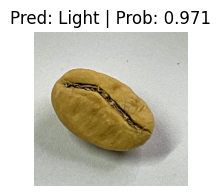

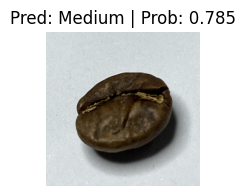

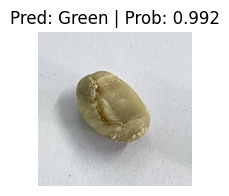

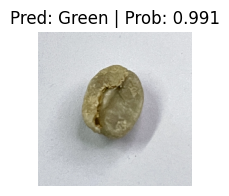

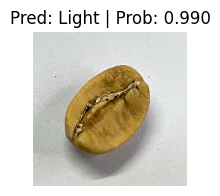

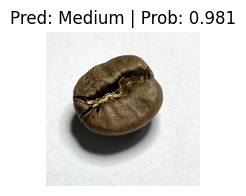

In [27]:
model_path = "models/effnetb1_10_epochs.pth"
model, weights = build_effnetb1(mps_device)
model.load_state_dict(torch.load(model_path))

import random
num_images_to_plot = 10
test_image_path_sample = random.sample(population=test_path_list,
                                       k=num_images_to_plot) # randomly select k number of images


for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=model_transforms,
                        image_size=(255, 255))


In [25]:
model.to("cpu")
from typing import Tuple, Dict

def predict(img) -> Dict:
    
    # img = Image.open(img)
    model.to("cpu")

    model.eval()
    with torch.inference_mode():
        transformed_image = model_transforms(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to("cpu"))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    print(target_image_pred_probs)
    pred_labels_and_probs = {class_names[i]: float(target_image_pred_probs[0][i]) for i in range(len(class_names))}

    return pred_labels_and_probs


In [28]:
import random
from PIL import Image

test_image_path_sample = random.sample(population=test_path_list,
                                       k=1)[0] 

print(test_image_path_sample)

image = Image.open(test_image_path_sample)
print(f"[INFO] Predicting on image at path: {test_image_path_sample}\n")

pred_dict = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")


test/Green/green (16).png
[INFO] Predicting on image at path: test/Green/green (16).png

tensor([[0.0011, 0.9905, 0.0047, 0.0037]])
Prediction label and probability dictionary: 
{'Dark': 0.0010852882405743003, 'Green': 0.9905056357383728, 'Light': 0.004693466704338789, 'Medium': 0.0037156289909034967}


In [29]:
import gradio as gr

title = "Coffee Bean Multi-classifier based on level of roasting ☕️"
description = """Created from multi-classifier model using transfer learning from [EfficientNetB1](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b1.html).
                Model was trained on 10 epochs on default weights, and demonstrated a testing accuarcy of 98%.\n Further information and the source code is provided at my [Github Repo](https://github.com/sehyunlee217/coffee_bean_multi_classification).
                \n\n There are four roasting levels: Green and lightly roasted coffee beans are Laos Typica Bolaven. Doi Chaang are the medium roasted, and Brazil Cerrado are dark roasted. All coffee beans are Arabica beans.\n"""
article = "Dataset from: Ontoum, S., Khemanantakul, T., Sroison, P., Triyason, T., & Watanapa, B. (2022). Coffee Roast Intelligence. arXiv preprint arXiv:2206.01841."

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=4, label="Predictions")],
                    examples=exp_list, 
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
